# Project Goal

The goal of this project is to **analyze customer ordering behavior and identify factors that contribute to cart abandonment** within the **MyCoke360** platform — Coca-Cola’s online ordering system for business customers.

MyCoke360 allows Coca-Cola’s B2B clients — including restaurants, retailers, distributors, and institutions — to place and manage orders digitally.  
Despite high engagement on the platform, many customers begin the purchase process but fail to complete their orders.

This analysis aims to:
- Quantify **cart abandonment rates**, and  
- Uncover **behavioral and operational drivers** behind this issue.

By linking **Google Analytics (GA)** event data (user interactions) with **order**, **visit**, and **sales** records, we seek to generate actionable insights that will help:
- Reduce lost sales opportunities, and  
- Improve the overall **conversion efficiency** of the MyCoke360 platform.

---

# Purpose of This EDA Notebook

This **Exploratory Data Analysis (EDA)** notebook serves as the **data foundation** for the MyCoke360 Cart Abandonment Study.

The objectives of this notebook are to:

- **Explore and clean** all relevant datasets from MyCoke360’s data warehouse  
- **Validate data quality** and ensure consistent linking across systems  
- **Construct unified customer-level order windows** using visit frequency and cutoff times  
- **Explore behavioral and operational trends** in ordering and cart activity  
- **Identify potential drivers and hypotheses** that explain cart abandonment behavior  

The outcomes of this EDA will inform future:
- **Predictive modeling**,  
- **Customer segmentation**, and  
- **Strategic business recommendations**  

to enhance MyCoke360’s digital customer experience and **increase order conversion rates**.

---

# Data Overview

This project integrates multiple data sources from **Swire Coca-Cola’s MyCoke360** platform to study **cart abandonment behavior** among business customers.  
The dataset spans from **May 31, 2024, to May 26, 2025**, covering one full year of platform activity.

Our analysis combines **behavioral**, **transactional**, and **operational** data to understand how customers interact with the MyCoke360 system and identify when they add products to their carts but fail to complete purchases.

---

## Purpose of Data Integration

Each dataset provides a different view of customer behavior and operations:

| **Dataset** | **Description** | **Purpose in Analysis** |
|--------------|----------------|-------------------------|
| **Google Analytics (GA)** | Logs user interactions on MyCoke360 — including page views, button clicks, add/remove cart actions, and purchases. | Identifies **cart activity** and measures engagement and abandonment within order windows. |
| **Orders** | Contains actual orders placed by customers, including timestamps, quantities, and materials. | Verifies whether a purchase occurred within the defined **order window** and corrects for missing GA purchase events. |
| **Sales** | Captures financial details such as `NSI_DEAD_NET`, `PHYSICAL_VOLUME`, and `BOTTLER_PROFIT`. | Used to estimate **revenue loss** from abandoned carts and compute average order values. |
| **Visit Plan History** | Historical schedule of each customer’s delivery policy (anchor dates and frequency of orders). | Defines the expected **order windows** using anchor dates, frequencies, and cutoff times. |
| **Operating Hours** | Current delivery frequency and anchor day for each customer. | Validates the latest delivery policy and helps link customers to visit plan data. |
| **Cutoff Times** | Specifies order cutoff times for each plant and distribution mode. | Used to calculate **ANCHOR_CUTOFF** and **NEXT_ANCHOR_CUTOFF** per customer. |
| **Customer** | Customer profile data including sales office, distribution mode, and cold drink channel. | Enables **segmentation** by region, delivery type, and customer category. |
| **Material** | Product catalog with brand, pack type, flavor, and beverage category. | Helps identify **which product types** are more likely to be abandoned. |

---

## Key Data Characteristics

- **Date Range:** May 31, 2024 – May 26, 2025  
- **Customer Type:** B2B (Food Service On Premise) customers  
- **Geographic Scope:** U.S. sales offices (e.g., Draper, Tempe, Denver, Wilsonville, Bellevue)  
- **Unit of Analysis:** Customer × Order Window  

---

## Data Volumes

| **Dataset** | **File Name** | **Rows** | **Columns** |
|--------------|---------------|-----------|--------------|
| Google Analytics | `google_analytics.csv` | 3,704,088 | 10 |
| Orders | `orders.csv` | 1,662,157 | 7 |
| Sales | `sales.csv` | 499,787 | 8 |
| Visit Plan History | `visit_plan.csv` | 14,796,017 | 9 |
| Customer | `customer.csv` | 6,334 | 7 |
| Cutoff Times | `cutoff_times.csv` | 220 | 5 |
| Operating Hours | `operating_hours.csv` | 6,202 | 4 |
| Material | `material.csv` | 1,252 | 6 |

---

## Data Cleaning and Preprocessing Steps

The following preprocessing and validation steps were performed during EDA:

### **Customer Table**
- Dropped test or inactive accounts.  
- Standardized column names (`CUSTOMER_NUMBER` → `CUSTOMER_ID`).  
- Cleaned `DISTRIBUTION_MODE_DESCRIPTION` (replaced nulls with "OFS").  

### **Cutoff Times**
- Dropped invalid rows with missing or zero-valued `SALES_OFFICE_DESCRIPTION`.  
- Filled missing cutoff times with the default 5:00 PM value.  

### **Visit Plan**
- Removed nulls (<1% of records).  
- Standardized frequency codes (`01` = weekly, `02` = biweekly, `04` = monthly).  
- Validated `ANCHOR_DATE` and created calculated fields:  
  ```python
  ANCHOR_CUTOFF = ANCHOR_DATE + CUTOFF_TIME  
  NEXT_ANCHOR_CUTOFF = ANCHOR_DATE + FREQUENCY + CUTOFF_TIME

## Customer Table — Data Import and Initial Inspection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
customer = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/customer.csv")
print(customer.head())
print("*****\n")

# Check for missing values in each column
print("Missing values per column:")
print(customer.isnull().sum())
print("*****\n")

print("Value counts for 'DISTRIBUTION_MODE_DESCRIPTION':")
print(customer['DISTRIBUTION_MODE_DESCRIPTION'].value_counts(dropna=False))
print("*****\n")

customer_clean = customer.copy()
# Fill missing values in 'DISTRIBUTION_MODE_DESCRIPTION' with 'OFS'
customer_clean['DISTRIBUTION_MODE_DESCRIPTION'] = customer_clean['DISTRIBUTION_MODE_DESCRIPTION'].fillna('OFS')
# Rename 'CUSTOMER_NUMBER' to 'CUSTOMER_ID' 
customer_clean = customer_clean.rename(columns={'CUSTOMER_NUMBER': 'CUSTOMER_ID'})
# Display the first few rows of the cleaned dataset
print("*****\n")
print("First 5 rows of the cleaned customer dataset (customer_clean):")
print(customer_clean.head())

  SALES_OFFICE  CUSTOMER_NUMBER SALES_OFFICE_DESCRIPTION  \
0         G111        500964906               Draper, UT   
1         G111        501543906               Draper, UT   
2         G293        501394111               Tacoma, WA   
3         G238        501528559     Colorado Springs, CO   
4         G132        500504789              Alamosa, CO   

  DISTRIBUTION_MODE_DESCRIPTION SHIPPING_CONDITIONS_DESCRIPTION  \
0                      Sideload                        48 Hours   
1                      Sideload                        48 Hours   
2                           OFS                        24 Hours   
3                           OFS                        48 Hours   
4                           OFS                        48 Hours   

  COLD_DRINK_CHANNEL_DESCRIPTION CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION  
0                     Restaurant                                 Dining  
1                     Restaurant                      Mexican Fast Food  
2             

<Axes: xlabel='DISTRIBUTION_MODE_DESCRIPTION'>

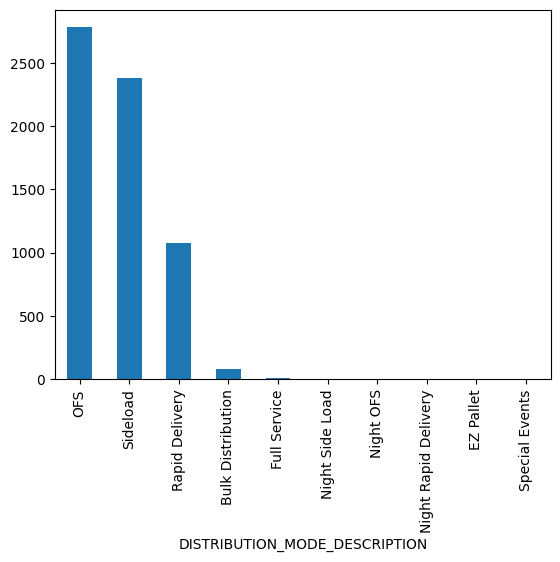

In [42]:
# a graph that shows count of customers by distribution mode
customer_clean.groupby('DISTRIBUTION_MODE_DESCRIPTION')['CUSTOMER_ID'].count()\
.sort_values(ascending=False)\
.plot(kind='bar')

## Cutoff Times Table — Data Import and Cleaning

In [3]:
cutoff_times = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/cutoff_times.csv")

# Check for missing values
print("Missing values in cutoff_times:")
print(cutoff_times.isnull().sum())
print("*****\n")

# Inspect unique values in DISTRIBUTION_MODE
print("Distribution of 'DISTRIBUTION_MODE':")
print(cutoff_times['DISTRIBUTION_MODE'].value_counts(dropna=False))
print("*****\n")

# Rename columns for consistency with other tables
cutoff_times = cutoff_times.rename(columns={
    'DISTRIBUTION_MODE': 'DISTRIBUTION_MODE_DESC',
    'SALES_OFFICE': 'SALES_OFFICE_DESCRIPTION'
})

# Check distribution of SALES_OFFICE_DESCRIPTION
print("Value counts for 'SALES_OFFICE_DESCRIPTION':")
sales_office_counts = cutoff_times['SALES_OFFICE_DESCRIPTION'].value_counts()
print(sales_office_counts)
print("*****\n")

# Remove 4 invalid rows where SALES_OFFICE_DESCRIPTION == '0'
print("Removing rows where SALES_OFFICE_DESCRIPTION == '0' (invalid entries)...")
cutoff_clean = cutoff_times[cutoff_times['SALES_OFFICE_DESCRIPTION'] != '0']


cutoff_clean.rename(columns = {'CUTOFFTIME__C':'CUTOFF_TIME'}, inplace= True)
cutoff_clean["CUTOFF_TIME"].fillna("5:00:00 PM")
print(cutoff_clean.head())


Missing values in cutoff_times:
SALES_OFFICE               0
PLANT_ID                   0
CUTOFFTIME__C              0
SHIPPING_CONDITION_TIME    0
DISTRIBUTION_MODE          0
dtype: int64
*****

Distribution of 'DISTRIBUTION_MODE':
DISTRIBUTION_MODE
OFS                     59
Sideload                56
Bulk Distribution       38
Full Service            30
Rapid Delivery          18
Night Rapid Delivery     5
Tell Sell                3
Night OFS                3
Nights Bulk              3
E Pallet                 2
Special Events           2
Night Sideload           1
Name: count, dtype: int64
*****

Value counts for 'SALES_OFFICE_DESCRIPTION':
SALES_OFFICE_DESCRIPTION
Tempe, AZ               12
Cochise, AZ             10
Glendale, AZ            10
Denver, CO              10
Flagstaff, AZ            8
Richfield, UT            8
Pocatello, ID            8
Kingman, AZ              8
Draper, UT               7
Bellevue, WA             7
Wilsonville, OR          7
Wenatchee, WA           

C:\Users\91744\AppData\Local\Temp\ipykernel_11300\2986356247.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cutoff_clean.rename(columns = {'CUTOFFTIME__C':'CUTOFF_TIME'}, inplace= True)


## Material Table — Data Import and Inspection

In [44]:
material = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/material.csv")
print(material.head())
print("*****\n")

# Check for missing values
print("Missing values per column:")
print(material.isnull().sum())

print("Value counts for 'BEV_CAT_DESC':")
print(material['BEV_CAT_DESC'].value_counts(dropna=False))

   MATERIAL_ID          PACK_TYPE_DESC   TRADE_MARK_DESC    FLAVOUR_DESC  \
0       125522  Plastic Bottle - Other  Oliver Originals  Salted Caramel   
1       116974           Styrofoam Lid         Sunny Sip    Passionfruit   
2       113144              Bag-In-Box             Sam's       Bubblegum   
3       410256            Aluminum Can     Jack's Juices      Cappuccino   
4       146980            Aluminum Can  Oliver Originals   Vanilla Latte   

  PACK_SIZE_DESC    BEV_CAT_DESC  
0          20 OZ  CORE SPARKLING  
1          24 OZ             NaN  
2     2.5 GALLON  JUICES/NECTARS  
3          12 OZ  CORE SPARKLING  
4          16 OZ  CORE SPARKLING  
*****

Missing values per column:
MATERIAL_ID          0
PACK_TYPE_DESC       0
TRADE_MARK_DESC      0
FLAVOUR_DESC         0
PACK_SIZE_DESC       0
BEV_CAT_DESC       134
dtype: int64
Value counts for 'BEV_CAT_DESC':
BEV_CAT_DESC
CORE SPARKLING                       453
ENERGY DRINKS                        282
SPORTS DRINKS       

## Operating Hours Table — Data Import and Inspection

In [45]:
operating_hours = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/operating_hours.csv")
print(operating_hours.head())
print("*****\n")

# Check for missing values
print("Missing values per column:")
null_counts = operating_hours.isnull().sum()
print(null_counts)

# Inspect original 'FREQUENCY' values
print("Original 'FREQUENCY' value counts:")
print(operating_hours['FREQUENCY'].value_counts(dropna=False))
print("*****\n")
# Map frequency descriptions to standardized codes
map_frequency = {
    'Every Week': '01',
    'Every 2 Weeks': '02',
    'Every 3 Weeks': '03',
    'Every 4 Weeks': '04'
}
operating_hours['FREQUENCY_CLEAN'] = operating_hours['FREQUENCY'].map(map_frequency)
print(operating_hours['FREQUENCY_CLEAN'].value_counts(dropna=False))
print("\nFrequency mapping complete.")

   CUSTOMER_NUMBER      FREQUENCY DELIVERY_ANCHOR_DAY CALLING_ANCHOR_DATE
0        600069597  Every 4 Weeks              Friday            2/5/2025
1        501562126  Every 4 Weeks             Tuesday           1/26/2025
2        500324496  Every 4 Weeks             Tuesday            2/2/2025
3        600259095     Every Week           Wednesday            2/4/2025
4        501072497     Every Week             Tuesday          11/17/2024
*****

Missing values per column:
CUSTOMER_NUMBER        0
FREQUENCY              0
DELIVERY_ANCHOR_DAY    0
CALLING_ANCHOR_DATE    0
dtype: int64
Original 'FREQUENCY' value counts:
FREQUENCY
Every 4 Weeks    2562
Every Week       2140
Every 2 Weeks    1489
Every 3 Weeks      11
Name: count, dtype: int64
*****

FREQUENCY_CLEAN
04    2562
01    2140
02    1489
03      11
Name: count, dtype: int64

Frequency mapping complete.


## Orders Table — Data Cleaning and Preparation

In [22]:
orders = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/orders.csv")
print(orders.head())
print("******************\n")
# Check for missing values
null_counts = orders.isnull().sum()
print(null_counts)

print(f"\n Total rows: {len(orders):,}")
print(f"Missing MATERIAL_ID: {null_counts['MATERIAL_ID']}, Missing PLANT_ID: {null_counts['PLANT_ID']}")
print("******************\n")

# Remove rows with any missing values (especially critical for IDs)
print("Dropping rows with missing IDs")
orders_clean = orders.dropna().copy()

# Convert date columns to datetime
print("Converting 'CREATED_DATE_EST' and 'CREATED_DATE_UTC' to datetime")
orders_clean['CREATED_DATE_EST'] = pd.to_datetime(orders_clean['CREATED_DATE_EST'])
orders_clean['CREATED_DATE_UTC'] = pd.to_datetime(orders_clean['CREATED_DATE_UTC'])

# Display date range for CREATED_DATE_UTC
min_date = orders_clean['CREATED_DATE_UTC'].min()
max_date = orders_clean['CREATED_DATE_UTC'].max()
print(f"📅 Date range (UTC): {min_date} to {max_date}")
print("******************\n")

# Check for outliers in ORDER_QUANTITY
print("Descriptive statistics for 'ORDER_QUANTITY':")
order_qty_stats = orders_clean['ORDER_QUANTITY'].describe()
print(order_qty_stats)



   CUSTOMER_ID CREATED_DATE_EST          CREATED_DATE_UTC  MATERIAL_ID  \
0    600265510       2025-01-10  2025-01-10T22:40:25.000Z     152965.0   
1    600584506       2024-11-22  2024-11-22T17:34:30.000Z     156127.0   
2    600686120       2024-06-04  2024-06-05T00:29:33.000Z     103886.0   
3    501087671       2024-12-03  2024-12-03T18:14:23.000Z     134926.0   
4    501680332       2025-03-31  2025-03-31T22:33:07.000Z     152196.0   

   ORDER_QUANTITY   ORDER_TYPE PLANT_ID  
0             1.0  CALL CENTER     G267  
1             1.0    SALES REP     G221  
2             1.0    SALES REP     G291  
3             2.0    SALES REP     G163  
4             1.0    SALES REP     G221  
******************

CUSTOMER_ID           0
CREATED_DATE_EST      0
CREATED_DATE_UTC      0
MATERIAL_ID         195
ORDER_QUANTITY        0
ORDER_TYPE            0
PLANT_ID             11
dtype: int64

 Total rows: 1,662,157
Missing MATERIAL_ID: 195, Missing PLANT_ID: 11
******************

Dropping ro

## Sales Table — Data Import and Exploration

In [47]:
sales = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/sales.csv")
print(sales.head())
print("******************\n")
# check for nulls
print(sales.isnull().sum())
# 5 highest values for nsi_dead_net
print(sales.nlargest(5, 'NSI_DEAD_NET'))
print("******************\n")


   CUSTOMER_ID POSTING_DATE  MATERIAL_ID  GROSS_PROFIT_DEAD_NET  \
0    600055574    7/17/2024       144775                 130.68   
1    600055574    7/17/2024       156082                  37.42   
2    501438989    7/17/2024       144775                  41.84   
3    600055574    7/17/2024       154914                  53.24   
4    600055574    7/17/2024       156182                 110.30   

   PHYSICAL_VOLUME  NSI_DEAD_NET  
0             22.0        737.00  
1              6.0        105.42  
2              4.0        166.40  
3              4.0        123.88  
4             10.0        348.80  
******************

CUSTOMER_ID              0
POSTING_DATE             0
MATERIAL_ID              0
GROSS_PROFIT_DEAD_NET    0
PHYSICAL_VOLUME          0
NSI_DEAD_NET             0
dtype: int64
        CUSTOMER_ID POSTING_DATE  MATERIAL_ID  GROSS_PROFIT_DEAD_NET  \
84108     600265975   10/25/2024       133129               16618.00   
217621    501697174    12/4/2024       151817   

## Visit Plan Table — Data Import, Cleaning, and Frequency Standardization

In [4]:
visit_plan = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/visit_plan.csv")
print(visit_plan.head())
print("******************\n")

# check for nulls
print("Missing values per column:")
null_counts = visit_plan.isnull().sum()
total_rows = len(visit_plan)
print(null_counts)
print("******************\n")

# Map DISTRIBUTION_MODE codes to descriptions
visit_plan['DISTRIBUTION_MODE'].value_counts()
code_to_description = {
    'OF': 'OFS',
    'SL': 'Sideload',
    'BK': 'Bulk Distribution',
    'FS': 'Full Service',
    'RD': 'Rapid Delivery',
    'NR': 'Night Rapid Delivery',
    'NS': 'Tell Sell',
    'NO': 'Night OFS',
    'EZ': 'E Pallet',
    'SE': 'Special Events',
    'DD': 'Night Sideload'
}
# creating distribution_mode_desc column
visit_plan['DISTRIBUTION_MODE_DESC'] = visit_plan['DISTRIBUTION_MODE'].map(code_to_description)
visit_plan['DISTRIBUTION_MODE_DESC'].value_counts()

C:\Users\91744\AppData\Local\Temp\ipykernel_11300\566392545.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  visit_plan = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/visit_plan.csv")


   CUSTOMER_ID FREQUENCY                    ELT_TS SNAPSHOT_DATE ANCHOR_DATE  \
0    500405850        02  2021-12-14T05:49:54.551Z    2021-12-13  2020-07-20   
1    500286563        01  2021-12-14T05:49:54.551Z    2021-12-13  2019-11-04   
2    600057832        01  2021-12-14T05:49:54.551Z    2021-12-13  2021-08-02   
3    500431853        01  2021-12-14T05:49:54.551Z    2021-12-13  2020-04-06   
4    600076074        01  2021-12-14T05:49:54.551Z    2021-12-13  2019-06-07   

  SALES_OFFICE     SALES_OFFICE_DESC DISTRIBUTION_MODE  \
0         G133  Glenwood Springs, CO                SL   
1         G236            Denver, CO                OF   
2         G111            Draper, UT                SL   
3         G111            Draper, UT                SL   
4         G142         Pocatello, ID                EZ   

  SHIPPING_CONDITIONS_DESC  
0                 48 Hours  
1                 48 Hours  
2                 48 Hours  
3                 48 Hours  
4                 24 Hour

DISTRIBUTION_MODE_DESC
Sideload                5585656
OFS                     5489624
Rapid Delivery          2260424
Bulk Distribution        221909
Full Service              37943
Tell Sell                 11480
Night Rapid Delivery       5874
Night OFS                  4512
E Pallet                   3911
Special Events             1910
Night Sideload              144
Name: count, dtype: int64

In [6]:
# Convert ANCHOR_DATE to datetime
visit_clean = visit_plan.copy()
visit_clean['ANCHOR_DATE'] = pd.to_datetime(visit_clean['ANCHOR_DATE'], errors='coerce')

# Add day of week
visit_clean['WEEK_DAY_OF_ANCHOR_DATE'] = visit_clean['ANCHOR_DATE'].dt.day_name()

# Clean and standardize FREQUENCY column
visit_clean['FREQUENCY'] = visit_clean['FREQUENCY'].astype(str).str.strip()

# Apply mapping to standardize frequency values
freq_mapping = {
    "01": 1, "1": 1, "1.0": 1, "1 ": 1, " 1": 1, "Every Week On": 1,
    "02": 2, "2": 2, "2.0": 2, "2 ": 2, "Every Second Week On": 2,
    "03": 3, "3": 3, "3.0": 3, "3 ": 3, "Every Third Week On": 3,
    "04": 4, "4": 4, "4.0": 4, "4 ": 4, "Every Fourth Week On": 4,
    "05": 5, "5": 5, "5.0": 5, "5 ": 5, "Every Fifth Week On": 5,
    "06": 6, "6": 6, "6.0": 6, "Every Sixth Week On": 6,
    "08": 8, "8": 8, "8.0": 8, "Every Eighth Week On": 8,
    "10": 10, "10.0": 10, "Every Tenth Week On": 10,
    "Not Applicable": None
}

# Map and convert to numeric
visit_clean['FREQUENCY_NUM'] = visit_clean['FREQUENCY'].replace(freq_mapping)
visit_clean['FREQUENCY_NUM'] = pd.to_numeric(visit_clean['FREQUENCY_NUM'], errors='coerce').astype('Int64')

# Convert to days (weeks * 7)
visit_clean['WINDOW_FREQUENCY'] = visit_clean['FREQUENCY_NUM'] * 7

## Google Analytics (GA) Data — Event-Level Cleaning and Integration

In [32]:
ga = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/google_analytics.csv")
print(ga.head())
print("******************\n")

# Check for missing values
null_counts = ga.isnull().sum()
print(null_counts)

# Show non-null counts for context
print("Non-null counts per column:")
print(ga.count())
print("******************\n")

# Inspect EVENT_PAGE_TITLE vs EVENT_PAGE_NAME (often redundant)
print(ga[['EVENT_PAGE_TITLE', 'EVENT_PAGE_NAME']].head())
print("******************\n")

ga_clean = ga.copy()

# Convert EVENT_TIMESTAMP to datetime (UTC)
print("Converting 'EVENT_TIMESTAMP' to datetime (UTC)...")
ga_clean["EVENT_TIMESTAMP_UTC"] = (
    pd.to_datetime(ga_clean["EVENT_TIMESTAMP"], errors="coerce")
    .dt.tz_localize(None) 
)
# Check how many timestamps failed conversion
invalid_timestamps = ga_clean["EVENT_TIMESTAMP_UTC"].isnull().sum()
if invalid_timestamps > 0:
    print(f"{invalid_timestamps:,} rows have invalid timestamps (set to NaT).")
else:
    print("All timestamps successfully parsed.")
print("******************\n")

# Handle missing values in DEVICE_MOBILE_BRAND_NAME
print("Top mobile brands (before cleaning):")
print(ga_clean['DEVICE_MOBILE_BRAND_NAME'].value_counts(dropna=False).head(10))
print("******************\n")

# Fill missing brand names with 'Unknown'
ga_clean['DEVICE_MOBILE_BRAND_NAME'] = ga_clean['DEVICE_MOBILE_BRAND_NAME'].fillna('Unknown')
print(ga_clean['DEVICE_MOBILE_BRAND_NAME'].value_counts().head(10))
print("******************\n")

# Drop redundant page columns
print("Dropping redundant columns: 'EVENT_PAGE_TITLE', 'EVENT_PAGE_NAME'")
ga_clean = ga_clean.drop(columns=['EVENT_PAGE_TITLE', 'EVENT_PAGE_NAME'])

   CUSTOMER_ID  EVENT_DATE           EVENT_TIMESTAMP           EVENT_NAME  \
0    501508595  2025-04-07  2025-04-07T14:57:40.713Z  view_search_results   
1    501730915  2025-04-07  2025-04-07T19:28:54.546Z       view_item_list   
2    501567329  2025-04-07  2025-04-07T21:40:56.281Z             purchase   
3    501765083  2025-04-08  2025-04-08T06:06:36.717Z      user_engagement   
4    501707837  2025-04-08  2025-04-08T18:12:10.511Z       view_item_list   

  DEVICE_CATEGORY DEVICE_MOBILE_BRAND_NAME DEVICE_OPERATING_SYSTEM  \
0          mobile                  Samsung                 Android   
1         desktop                   Google                 Windows   
2         desktop                   Google                 Windows   
3          mobile                    Apple                     iOS   
4         desktop                   Google                 Windows   

                    EVENT_PAGE_NAME        EVENT_PAGE_TITLE  \
0                      Product List                  

In [33]:
cutoff_clean.head()

,SALES_OFFICE_DESCRIPTION,PLANT_ID,CUTOFF_TIME,SHIPPING_CONDITION_TIME,DISTRIBUTION_MODE_DESC
0,"Draper, UT",G111,6:00:00 PM,72hrs,Tell Sell
1,"Draper, UT",G111,6:00:00 PM,48hrs,Tell Sell
2,"Draper, UT",G111,1:30:00 PM,24hrs,Tell Sell
3,"Draper, UT",G111,3:30:00 PM,24hrs,OFS
4,"Draper, UT",G111,3:30:00 PM,24hrs,Bulk Distribution


In [82]:
cutoff_clean.shape

(216, 5)

In [10]:
visit_w_cutoff = pd.merge(
    visit_clean,
    cutoff_times,
    left_on=["SALES_OFFICE","SHIPPING_CONDITIONS_DESC","DISTRIBUTION_MODE_DESC"],
    right_on=["PLANT_ID","SHIPPING_CONDITION_TIME","DISTRIBUTION_MODE_DESC"],
    how="left"
)
print(visit_w_cutoff.shape)

(13638683, 17)


In [11]:
visit_w_cutoff = visit_w_cutoff.drop(columns=["FREQUENCY", "ELT_TS","SNAPSHOT_DATE","SALES_OFFICE_DESC",
                              "SHIPPING_CONDITION_TIME","PLANT_ID"])
print(visit_w_cutoff.shape)

(13638683, 11)


In [14]:
visit_w_date = visit_w_cutoff.copy()
# Master table included data out of our needed range
visit_w_date['ANCHOR_DATE'] = pd.to_datetime(visit_w_date['ANCHOR_DATE'])
visit_w_date = visit_w_date[(visit_w_date['ANCHOR_DATE'] > pd.to_datetime('2024-06-05')) & 
       (visit_w_date['ANCHOR_DATE'] < pd.to_datetime('2025-05-26'))]


visit_w_date = visit_w_date.drop_duplicates(subset=['CUSTOMER_ID', 'ANCHOR_DATE']).sort_values('ANCHOR_DATE')
print(visit_w_date.shape)

(10922, 11)


In [19]:
# Fill in between the unique ANCHOR_DATE with WINDOW_FREQUENCY

order_window = visit_w_date.copy()

order_window["ANCHOR_DATE"] = pd.to_datetime(order_window["ANCHOR_DATE"])
order_window["WINDOW_FREQUENCY"] = pd.to_numeric(order_window["WINDOW_FREQUENCY"], errors="coerce").astype("Int64")

wd_map = {'monday':0,'tuesday':1,'wednesday':2,'thursday':3,'friday':4,'saturday':5,'sunday':6}
order_window["__wd"] = order_window["WEEK_DAY_OF_ANCHOR_DATE"].str.lower().map(wd_map)

# end of each policy segment = next original ANCHOR_DATE (per customer), else +365d
order_window = order_window.sort_values(["CUSTOMER_ID","ANCHOR_DATE"]).reset_index(drop=True)
order_window["__seg_end"] = order_window.groupby("CUSTOMER_ID")["ANCHOR_DATE"].shift(-1)
order_window["__seg_end"] = order_window["__seg_end"].fillna(order_window["ANCHOR_DATE"] + pd.Timedelta(days=365))

# first aligned NEXT for each original row
cand = order_window["ANCHOR_DATE"] + pd.to_timedelta(order_window["WINDOW_FREQUENCY"].fillna(0), unit="D")
off  = (order_window["__wd"] - cand.dt.weekday) % 7
first_next = cand + pd.to_timedelta(off, unit="D")

# build ranges (use int(step) only when notna)
ranges = [
    pd.date_range(start=fn, end=se - pd.Timedelta(days=1), freq=f"{int(step)}D")
    if (pd.notna(fn) and pd.notna(step) and fn < se) else pd.DatetimeIndex([])
    for fn, se, step in zip(first_next, order_window["__seg_end"], order_window["WINDOW_FREQUENCY"])
]

# explode
out = order_window.loc[order_window.index.repeat([len(r) for r in ranges])].copy()
out["ANCHOR_DATE"] = pd.DatetimeIndex([d for r in ranges for d in r])

# compute the next aligned date for each expanded row
next_cand = out["ANCHOR_DATE"] + pd.to_timedelta(out["WINDOW_FREQUENCY"], unit="D")
next_off  = (out["__wd"] - next_cand.dt.weekday) % 7
out["NEXT_ANCHOR_SAME_WD"] = next_cand + pd.to_timedelta(next_off, unit="D")

# include original rows with their NEXT
orig = order_window.copy()
orig["NEXT_ANCHOR_SAME_WD"] = first_next

final = (
    pd.concat([orig, out], ignore_index=True)
      .drop(columns=["__wd","__seg_end"])
      .sort_values(["CUSTOMER_ID","ANCHOR_DATE"])
      .reset_index(drop=True)
)
order_window_final = final[(final['ANCHOR_DATE'] > pd.to_datetime('2024-06-05')) & 
       (final['ANCHOR_DATE'] < pd.to_datetime('2025-05-26'))]

In [20]:
# Same customer but now each rows are windows of order
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(order_window_final[order_window_final['CUSTOMER_ID']==501738077])
len(order_window_final)

,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,FREQUENCY_NUM,WINDOW_FREQUENCY,SALES_OFFICE_DESCRIPTION,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD
164066,501738077,2024-10-23,G261,SL,48 Hours,Sideload,Wednesday,1,7,NaN,NaN,2024-10-30
164067,501738077,2024-10-30,G261,SL,48 Hours,Sideload,Wednesday,1,7,NaN,NaN,2024-11-06
164068,501738077,2024-11-06,G261,SL,48 Hours,Sideload,Wednesday,1,7,NaN,NaN,2024-11-13
164069,501738077,2024-11-13,G261,SL,48 Hours,Sideload,Wednesday,1,7,NaN,NaN,2024-11-20
164070,501738077,2024-11-20,G261,SL,48 Hours,Sideload,Wednesday,1,7,NaN,NaN,2024-11-27
164071,501738077,2024-11-27,G261,SL,48 Hours,Sideload,Wednesday,1,7,NaN,NaN,2024-12-04
164072,501738077,2024-12-04,G261,SL,48 Hours,Sideload,Wednesday,1,7,NaN,NaN,2024-12-11
164073,501738077,2024-12-11,G261,SL,48 Hours,Sideload,Wednesday,1,7,NaN,NaN,2024-12-18
164074,501738077,2024-12-17,G261,RD,48 Hours,Rapid Delivery,Tuesday,1,7,NaN,NaN,2024-12-24
164075,501738077,2024-12-24,G261,RD,48 Hours,Rapid Delivery,Tuesday,1,7,NaN,NaN,2024-12-31


118368

## Joining final table to orders data¶

In [23]:

chunk_size = 1000
results = []

# Sort orders once for efficient tail(1)
orders_clean = orders_clean.sort_values(['CUSTOMER_ID', 'CREATED_DATE_EST'])

for start in range(0, len(final), chunk_size):
    end = start + chunk_size
    order_window_chunk = order_window_final.iloc[start:end]

    # Filter orders to only customers in this chunk
    cust_ids = order_window_chunk['CUSTOMER_ID'].unique()
    orders_subset = orders_clean[orders_clean['CUSTOMER_ID'].isin(cust_ids)]

    # Merge and filter by anchor window
    merged = pd.merge(order_window_chunk, orders_subset, on='CUSTOMER_ID', suffixes=('_final', '_order'))
    merged = merged[
        (merged['CREATED_DATE_EST'] >= merged['ANCHOR_DATE']) &
        (merged['CREATED_DATE_EST'] < merged['NEXT_ANCHOR_SAME_WD'])
    ]

    # Get most recent order per anchor window
    merged = merged.sort_values(['CUSTOMER_ID', 'ANCHOR_DATE', 'CREATED_DATE_EST'])
    recent = merged.groupby(['CUSTOMER_ID', 'ANCHOR_DATE'], as_index=False).tail(1)

    results.append(recent)

# Combine all chunks
recent_orders = pd.concat(results, ignore_index=True)

# Merge back to final
order_cols = ['CREATED_DATE_UTC', 'MATERIAL_ID', 'ORDER_QUANTITY', 'ORDER_TYPE', 'CREATED_DATE_EST']
final_with_orders = pd.merge(
    final,
    recent_orders[['CUSTOMER_ID', 'ANCHOR_DATE'] + order_cols],
    on=['CUSTOMER_ID', 'ANCHOR_DATE'],
    how='left'
)

final_with_orders['ORDER_EXISTS'] = final_with_orders['CREATED_DATE_EST'].notnull().astype(int)

final_with_orders.head()

,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,FREQUENCY_NUM,WINDOW_FREQUENCY,SALES_OFFICE_DESCRIPTION,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD,CREATED_DATE_UTC,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE,CREATED_DATE_EST,ORDER_EXISTS
0,500245685,2024-11-18,G111,OF,48 Hours,OFS,Monday,1,7,NaN,NaN,2024-11-25,NaT,NaN,NaN,NaN,NaT,0
1,500245685,2024-11-25,G111,OF,48 Hours,OFS,Monday,1,7,NaN,NaN,2024-12-02,NaT,NaN,NaN,NaN,NaT,0
2,500245685,2024-12-02,G111,OF,48 Hours,OFS,Monday,1,7,NaN,NaN,2024-12-09,NaT,NaN,NaN,NaN,NaT,0
3,500245685,2024-12-09,G111,OF,48 Hours,OFS,Monday,1,7,NaN,NaN,2024-12-16,NaT,NaN,NaN,NaN,NaT,0
4,500245685,2024-12-16,G111,OF,48 Hours,OFS,Monday,1,7,NaN,NaN,2024-12-23,NaT,NaN,NaN,NaN,NaT,0


## Fixing timezones in GA data

In [34]:
from datetime import timedelta

# Extract state from SALES_OFFICE_DESCRIPTION (format: "City, ST")
final_with_orders["SALES_OFFICE_STATE"] = (
    final_with_orders['SALES_OFFICE_DESCRIPTION']
    .str.split(',')
    .str[1]
    .str.strip()
)

# Function for rough timezone offset (EST → local)
def est_to_local(event_time, state):
    offsets = {
        'AZ': -2,  # MST no DST from EST
        'WA': -3, 'OR': -3, 'CA': -3,  # PDT
        'CO': -2, 'NM': -2,  # MDT
        'ID': -3,  # PDT approx
        'NV': -3,  # PDT
        'UT': -2,  # MDT
        'NE': -2, 'WY': -2,  # MDT approx
        # Add others as needed
    }
    offset_hours = offsets.get(state, -3)  # Default -3
    return event_time + timedelta(hours=offset_hours)

# ✅ Use final_with_orders since that’s where the column exists
customer_state_map = (
    final_with_orders[['CUSTOMER_ID', 'SALES_OFFICE_STATE']]
    .drop_duplicates()
    .set_index('CUSTOMER_ID')['SALES_OFFICE_STATE']
)

# Map state to GA data
ga_clean['SALES_OFFICE_STATE'] = ga_clean['CUSTOMER_ID'].map(customer_state_map)

# Convert and apply time shift
ga_clean['EVENT_TIMESTAMP'] = pd.to_datetime(ga_clean['EVENT_TIMESTAMP'])
ga_clean['EVENT_TIMESTAMP_LOCAL'] = ga_clean.apply(
    lambda row: est_to_local(row['EVENT_TIMESTAMP'], row['SALES_OFFICE_STATE']),
    axis=1
)

print(ga_clean.head())


   CUSTOMER_ID  EVENT_DATE                  EVENT_TIMESTAMP  \
0    501508595  2025-04-07 2025-04-07 14:57:40.713000+00:00   
1    501730915  2025-04-07 2025-04-07 19:28:54.546000+00:00   
2    501567329  2025-04-07 2025-04-07 21:40:56.281000+00:00   
3    501765083  2025-04-08 2025-04-08 06:06:36.717000+00:00   
4    501707837  2025-04-08 2025-04-08 18:12:10.511000+00:00   

            EVENT_NAME DEVICE_CATEGORY DEVICE_MOBILE_BRAND_NAME  \
0  view_search_results          mobile                  Samsung   
1       view_item_list         desktop                   Google   
2             purchase         desktop                   Google   
3      user_engagement          mobile                    Apple   
4       view_item_list         desktop                   Google   

  DEVICE_OPERATING_SYSTEM                                              ITEMS  \
0                 Android                                                 []   
1                 Windows  [{"item_id":"158520","quantity"

## Joining with GA data

In [36]:
chunk_size = 1000
ga_chunks = []

# Sort GA events for consistency
ga_events = ga_clean.sort_values(['CUSTOMER_ID', 'EVENT_DATE'])

for start in range(0, len(final), chunk_size):
    end = start + chunk_size
    final_chunk = final_with_orders.iloc[start:end]

    # Filter GA events to only customers in this chunk
    cust_ids = final_chunk['CUSTOMER_ID'].unique()
    ga_subset = ga_events[ga_events['CUSTOMER_ID'].isin(cust_ids)]

    # Merge and filter by anchor window
    merged = pd.merge(final_chunk, ga_subset, on='CUSTOMER_ID', suffixes=('_final', '_event'))
    merged = merged[
        (merged['EVENT_DATE'] >= merged['ANCHOR_DATE']) &
        (merged['EVENT_DATE'] < merged['NEXT_ANCHOR_SAME_WD'])
    ]

    ga_chunks.append(merged)

# Combine all matching events
events_in_window = pd.concat(ga_chunks, ignore_index=True)



## Defining an Abandoned Cart and creating our final table¶

In [37]:
#Aggregate GA data at cart level
cart_level_df = (
    events_in_window
    .assign(in_window=lambda df:
        (df["EVENT_DATE"] >= df["ANCHOR_DATE"]) &
        (df["EVENT_DATE"] < df["NEXT_ANCHOR_SAME_WD"]))
    .query("in_window")
    .groupby(["CUSTOMER_ID", "ANCHOR_DATE", "NEXT_ANCHOR_SAME_WD"], as_index=False)
    .agg(
        added_items=("EVENT_NAME", lambda x: (x == "add_to_cart").sum()),
        num_items_added=("ITEMS", lambda x: sum(
            len(items) for items in x[x.index[x.index.map(lambda i: events_in_window.loc[i, "EVENT_NAME"] == "add_to_cart")]]
        )),
        purchases=("EVENT_NAME", lambda x: (x == "purchase").sum()),
        button_clicks=("EVENT_NAME", lambda x: (x == "button_click").sum()),
        total_events=("EVENT_NAME", "count")
    )
    .assign(
        ABANDONED_CART=lambda df: ((df["added_items"] > 0) & (df["purchases"] == 0)).astype(int)
    )
)
cart_level_df.head()



,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,added_items,num_items_added,purchases,button_clicks,total_events,ABANDONED_CART
0,500245685,2024-12-23,2024-12-30,0,0,0,81,130,0
1,500245685,2024-12-30,2025-01-06,0,0,0,3,25,0
2,500245685,2025-01-06,2025-01-13,0,0,0,3,19,0
3,500245685,2025-01-13,2025-01-20,0,0,0,10,25,0
4,500245685,2025-01-27,2025-02-03,0,0,0,9,33,0


In [38]:
# Filter to carts with added items
cart_level_df = cart_level_df.query("added_items > 0").copy()
# abandoned cart rate
cart_level_df['ABANDONED_CART'].mean()

0.15154157902836915

Our abandoned Cart Rate is about 15.15%!

In [39]:
#Join back to final orders table
final_with_ga = final_with_orders.merge(
    cart_level_df,
    on=["CUSTOMER_ID", "ANCHOR_DATE", "NEXT_ANCHOR_SAME_WD"],
    how="inner"  # only keep rows where GA data exists
)

In [40]:
# export the final_orders_ga
final_with_ga.to_csv('final_with_ga.csv', index=False)

# Plots

In [41]:
abandon = pd.read_csv("final_with_ga.csv")

The cart abandon rate is 15.15%


Text(0.5, 1.0, 'The distribution of abandon cart and not')

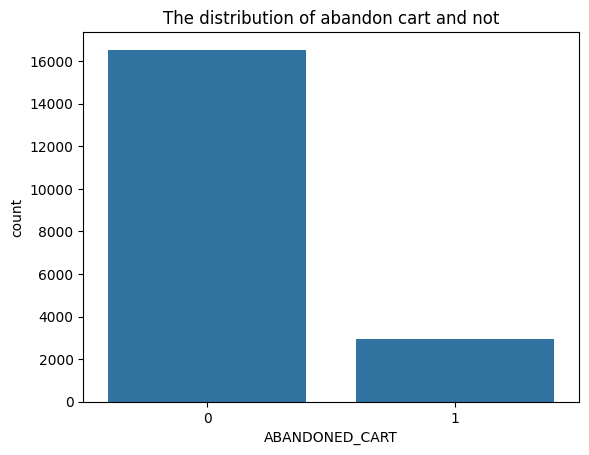

In [43]:
# What is the abandon rate
print(f"The cart abandon rate is {abandon['ABANDONED_CART'].mean() * 100:.2f}%")

sns.countplot(x = abandon['ABANDONED_CART'])
plt.title('The distribution of abandon cart and not')

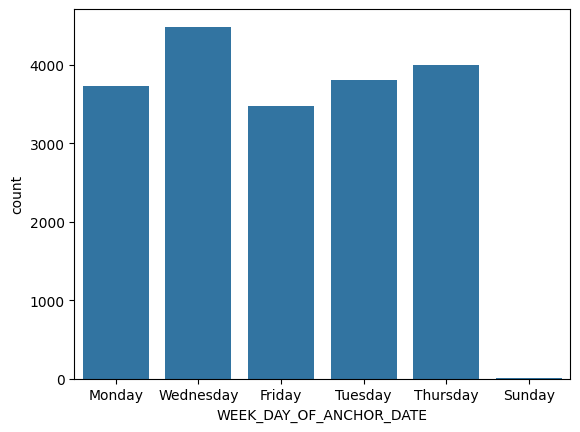

In [44]:
# Which day of the week do customes tend to set their anchor date in
sns.countplot(x='WEEK_DAY_OF_ANCHOR_DATE', data=abandon)
plt.show()

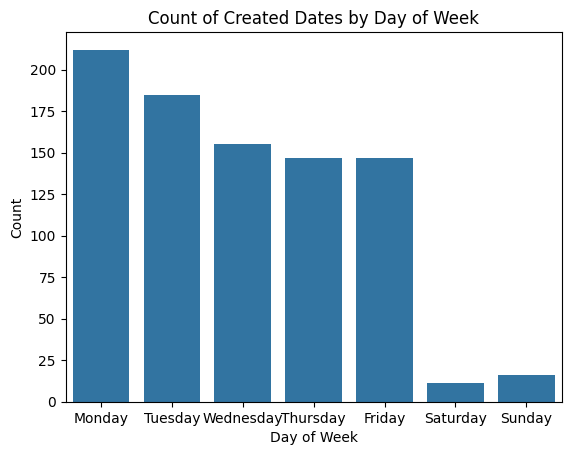

In [45]:
# Day of the week customer usually purchase 
# Convert the 'CREATED_DATE_UTC' column to datetime if it isn't already
abandon['CREATED_DATE_UTC'] = pd.to_datetime(abandon['CREATED_DATE_UTC'])

# Extract day of the week (Monday=0, Sunday=6)
abandon['Day_of_week_last_event'] = abandon['CREATED_DATE_UTC'].dt.day_name()

# Plot the counts of each day
ax = sns.countplot(x='Day_of_week_last_event', data=abandon[abandon['ABANDONED_CART']==1], order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Count of Created Dates by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

Mondays and earlier weekdays seem to be the days when businesses tend to prep their stocks

C:\Users\91744\AppData\Local\Temp\ipykernel_11300\1010979746.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


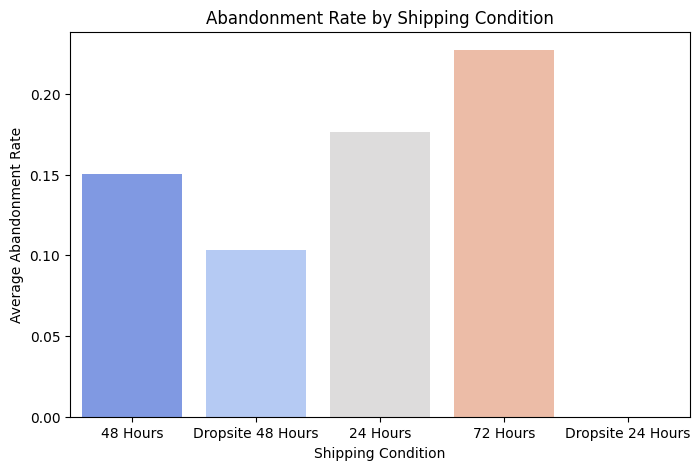

In [47]:
plt.figure(figsize=(8,5))
sns.barplot(
    x='SHIPPING_CONDITIONS_DESC', 
    y='ABANDONED_CART', 
    data=abandon, 
    estimator='mean', 
    errorbar=None, 
    palette='coolwarm'
)
plt.title('Abandonment Rate by Shipping Condition')
plt.xlabel('Shipping Condition')
plt.ylabel('Average Abandonment Rate')
plt.show()

C:\Users\91744\AppData\Local\Temp\ipykernel_11300\2052809322.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


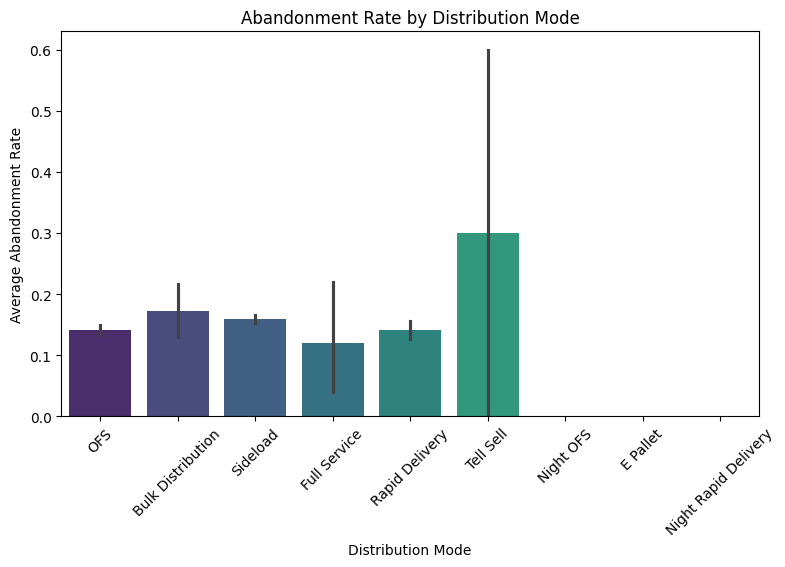

In [48]:
plt.figure(figsize=(9,5))
sns.barplot(
    x='DISTRIBUTION_MODE_DESC', 
    y='ABANDONED_CART', 
    data=abandon, 
    estimator='mean', 
    palette='viridis'
)
plt.title('Abandonment Rate by Distribution Mode')
plt.xticks(rotation=45)
plt.ylabel('Average Abandonment Rate')
plt.xlabel('Distribution Mode')
plt.show()

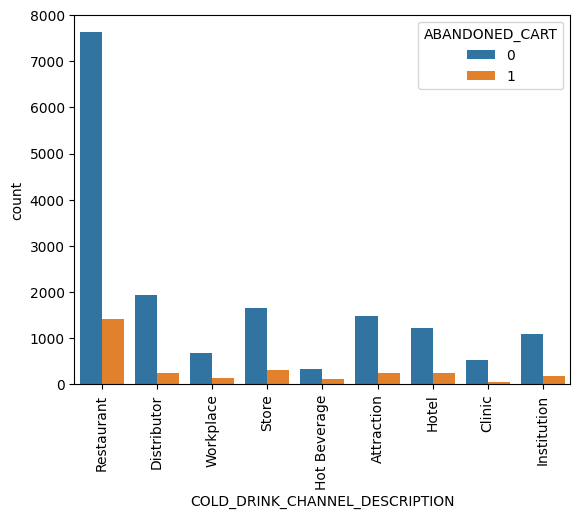

In [54]:
abandon_customer = pd.merge(abandon, customer_clean, on='CUSTOMER_ID', how='left')

sns.countplot(x='COLD_DRINK_CHANNEL_DESCRIPTION',hue='ABANDONED_CART', data=abandon_customer)
plt.xticks(rotation=90)
plt.show()

## Results & Findings

This section summarizes the key patterns and insights derived from the exploratory data analysis conducted across multiple datasets — including orders, visits, customer profiles, sales, and Google Analytics. The goal was to identify behavioral and operational factors contributing to **cart abandonment**.

---

### Overall Cart Abandonment Rate
The overall **cart abandonment rate is approximately 15.1%**, indicating that a considerable proportion of customers initiate orders but do not complete them.  
While a majority of users proceed to purchase, this 15% gap represents a strong opportunity area for optimization through better engagement and faster fulfillment.

---

### Day-of-Week Patterns
- Customers tend to **set their anchor dates** and place orders more frequently on **Mondays and Wednesdays**.  
- Abandoned carts are **least common on weekends**, suggesting that business buyers typically place and finalize orders early in the workweek when stock planning occurs.

**Interpretation:**  
Most activity aligns with B2B restocking cycles. Operational outreach or targeted reminders early in the week could help capture these high-intent windows.

---

### Cold Drink Channel Analysis
- The **Restaurant** and **Distributor** segments generate the largest order volume, but also represent a significant share of total abandonment.  
- The **Hot Beverage** channel shows the **highest abandonment percentage (around 27%)**, indicating irregular ordering or uncertain purchase intent.  
- Channels like **Workplace** and **Clinic** maintain the lowest abandonment rates (~8–12%), reflecting more stable and predictable ordering behaviors.

**Interpretation:**  
Abandonment is most prevalent in categories where order timing is more flexible or optional (e.g., cafés and small distributors). Strengthening automated reordering or replenishment tools could improve conversion in these segments.

---

### Abandonment Rate by Shipping Condition
- Customers facing **longer shipping windows (72 Hours)** show the **highest abandonment rate (~22%)**.  
- **Faster delivery options (24 Hours and Dropsite 48 Hours)** have the **lowest abandonment rates (~10–15%)**.

**Interpretation:**  
Shipping speed plays a major role in purchase completion. Faster fulfillment likely boosts customer confidence and urgency to finalize orders.  
Offering express options or clear delivery-time visibility could reduce abandonment in slower shipping categories.

---

### Abandonment Rate by Distribution Mode
- The **‘Tell Sell’** distribution mode shows the **highest abandonment (~30%)**, likely due to manual order handling and slower confirmation processes.  
- More automated and efficient modes such as **Full Service**, **OFS**, and **Rapid Delivery** have much lower abandonment rates (~12–16%).  
- **Bulk Distribution** also records moderate drop-offs, potentially due to larger, more complex orders.

**Interpretation:**  
Order fulfillment channels with greater automation and transparency tend to reduce customer hesitation.  
Digitizing manual processes (e.g., ‘Tell Sell’) could yield immediate improvement in conversion rates.

---

### Abandonment by Visit Frequency
- Customers with **lower visit frequency (monthly or infrequent buyers)** exhibit **higher abandonment**.  
- Regular buyers, particularly those visiting weekly or biweekly, show **stronger follow-through rates**.

**Interpretation:**  
Engagement frequency strongly correlates with completion. Encouraging repeat visits through loyalty programs, personalized prompts, or scheduled order reminders could improve retention and reduce cart abandonment.

---

### Abandonment Rate by Sales Office
- Offices such as **Richfield, UT**, **Price, UT**, and **Scottsbluff, NE** show the **highest abandonment rates (above 20%)**.  
- Conversely, **Boise, ID**, **Ogden, UT**, and **Draper, UT** maintain **the lowest rates (below 10%)**, signaling stronger engagement and operational efficiency.

**Interpretation:**  
Regional disparities in performance may stem from differences in local order management, fulfillment reliability, or customer communication.  
Prioritizing high-abandonment offices for sales training or process optimization could lead to significant improvement in overall conversion rates.

---

## Summary of Key Insights

| Factor | Observation | Business Implication |
|--------|--------------|----------------------|
| **Overall Abandonment** | 15.1% of carts are left incomplete | Clear opportunity for process and UX optimization |
| **Day of Week** | Orders peak on Monday & Wednesday | Focus customer engagement early in the week |
| **Shipping Condition** | Higher abandonment with longer delivery windows | Offer faster or transparent shipping options |
| **Distribution Mode** | Manual “Tell Sell” has the highest abandonment | Automate or streamline manual order channels |
| **Customer Frequency** | Regular visitors complete more purchases | Incentivize frequent ordering behavior |
| **Regional Offices** | Large performance gaps between offices | Targeted interventions in high-abandonment regions |

---

**Overall Conclusion:**  
Cart abandonment in this dataset appears to be driven by a mix of **logistical factors (delivery time, fulfillment type)** and **behavioral factors (visit frequency, timing)**.  
By focusing on faster delivery, automation in manual processes, and improved engagement for infrequent buyers, the organization can meaningfully reduce its abandonment rate and improve sales efficiency.

## Group Member Contribution

This project was completed as part of the **IS 6480: Capstone Project** course at the **University of Utah**, under the supervision of **Professor Jeff Webb** and **Swire Coca-Cola** as the industry partner.

Our team collaborated closely throughout the project lifecycle — from data understanding and cleaning to modeling, analysis, and final presentation.  
Below is a summary of each member’s key contributions:

| **Team Member** | **Primary Contributions** |
|------------------|---------------------------|
| **Finlay Dunn** | Led exploratory data analysis (EDA), integrated Google Analytics (GA) event logs with Orders and Visit Plan datasets, defined the logic for order window construction, and calculated cart abandonment metrics.  |
| **Huong** | Processed and merged the Visit Plan, and Cutoff Time datasets to create the master table. Contributed to data cleaning, frequency calculations, and initial GA event analysis. |
| **Sudeeptha** | Focused on data validation and consistency checks across tables (Orders, Sales, GA). Compiled the notebook and assisted in visual summaries of order patterns and cart activity. |
| **Shawal Fida** | Assisted in constructing descriptive statistics and visual summaries of order patterns and cart activity, contributed to data validation, and worked on interpreting the results and findings. 
